# CS445: Term Project

#### Victor Weeks & Josh Lutz

## Introduction

## Data

In [490]:
from gw2spidy import Gw2Spidy as spidy # allows retrieval of market information
import numpy as np
import json
import random
import neuralnetworksA4 as nn
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
itemIDs = (19718,19720,19697,19680,19719,19738,19723,19710,
           19739,19740,19699,19683,19703,19687,19728,19733,19726,19713,
           19741,19742,19698,19682,19730,19734,19727,19714,
           19743,19744,19702,19686,19731,19736,19736,19724,19711,
           19748,19747,19700,19684,19729,19735,19722,19709,
           19745,19746,19701,19685,19732,19737,19725,19712)

In [501]:
itemTimeData = np.load('itemData.npy')
itemTimeData.shape

(18768, 13)

In [493]:
names = ['item_id', 'max_offer_price', 'min_sale_price', 'offer_availability', 'sale_availability', 'sale_price_change', 'offer_price_change', 'year', 'month', 'day', 'hour', 'minute', 'second']

In [494]:
Xnames = names[1:7]
Tnames = names[1:7]

In [502]:
def makeItemData(itemID=19718, allItems=False, splitData=False, stepsAheadToPredict=4):
    itemTimeData = np.load('itemData.npy')
    if allItems:
        itemData = np.mean(itemTimeData[0:50], axis=0).reshape((1,-1))
        for bucket in itemTimeData[51::51]:
            itemData = np.vstack((itemData, np.mean(bucket.reshape((1,-1)), axis=0).reshape((1,-1))))
    else:
        itemData = itemTimeData[np.where(itemTimeData[:]==itemID)[0]]
    X = itemData[:-stepsAheadToPredict, 1:7].copy()
    T = itemData[stepsAheadToPredict:, 1:7].copy()
    if splitData:
        rows = np.arange(X.shape[0])
        nTrain = int(X.shape[0] * 0.7)
        Xtrain = X[rows[:nTrain],:]
        Ttrain = T[rows[:nTrain],:]
        Xtest = X[rows[nTrain:],:]
        Ttest = T[rows[nTrain:],:]
        return Xtrain, Ttrain, Xtest, Ttest
    else:        
        return X, T, itemData

Note: Had to make sure to copy the X and T data because of how the Time-Embedded data is accessed.

In [497]:
Xtrain, Ttrain, Xtest, Ttest = makeItemData(splitData=True)

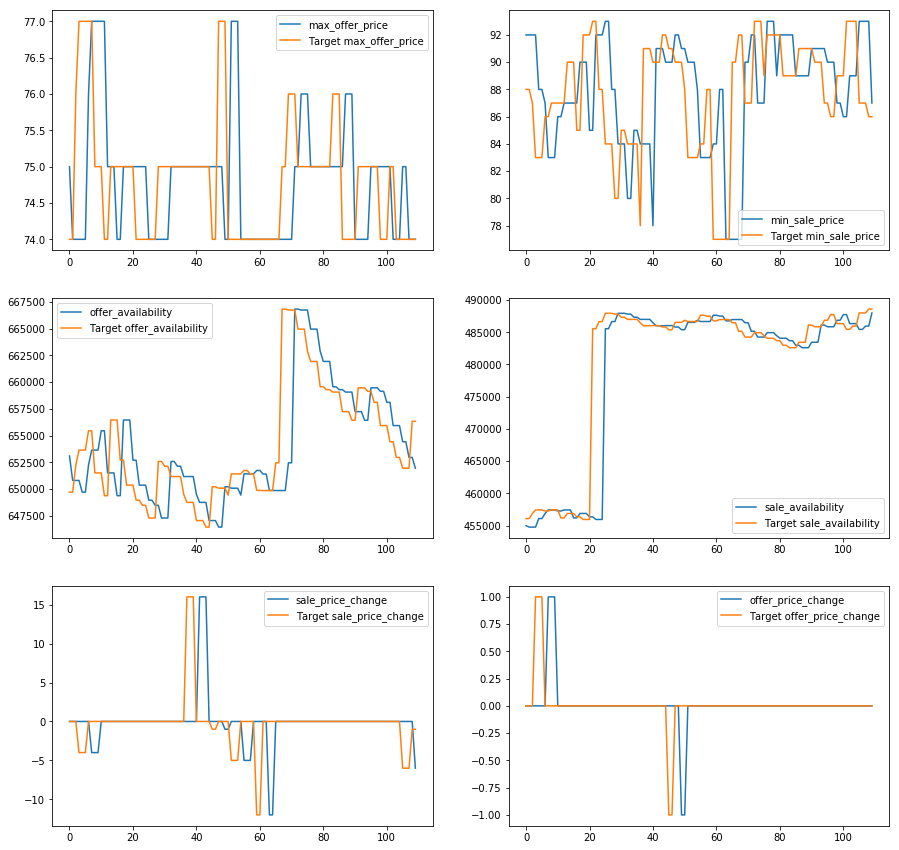

In [498]:
fig = plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.plot(Xtest[:,0], label=Xnames[0])
plt.plot(Ttest[:,0], label='Target ' + Tnames[0])
plt.legend();

plt.subplot(3,2,2)
plt.plot(Xtest[:,1], label=Xnames[1])
plt.plot(Ttest[:,1], label='Target ' + Tnames[1])
plt.legend();

plt.subplot(3,2,3)
plt.plot(Xtest[:,2], label=Xnames[2])
plt.plot(Ttest[:,2], label='Target ' + Tnames[2])
plt.legend();

plt.subplot(3,2,4)
plt.plot(Xtest[:,3], label=Xnames[3])
plt.plot(Ttest[:,3], label='Target ' + Tnames[3])
plt.legend();

plt.subplot(3,2,5)
plt.plot(Xtest[:,4], label=Xnames[4])
plt.plot(Ttest[:,4], label='Target ' + Tnames[4])
plt.legend();

plt.subplot(3,2,6)
plt.plot(Xtest[:,5], label=Xnames[5])
plt.plot(Ttest[:,5], label='Target ' + Tnames[5])
plt.legend();

## Methods

### Time-Embedding

In [15]:
def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

In [506]:
def rollingWindows(X, windowSize=4):    
    nSamples, nAttributes = X.shape
    nWindows = nSamples - windowSize + 1
    # Shape of resulting matrix
    newShape = (nWindows, nAttributes * windowSize)
    itemSize = X.itemsize  # number of bytes
    # Number of bytes to increment to starting element in each dimension
    strides = (nAttributes * itemSize, itemSize)
    return np.lib.stride_tricks.as_strided(X, shape=newShape, strides=strides)

In [416]:
XtrainW = rollingWindows(Xtrain, windowSize=9)
XtestW = rollingWindows(Xtest, windowSize=9)
TtrainW = Ttrain[:XtrainW.shape[0]]
TtestW = Ttest[:XtestW.shape[0]]
XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape

((345, 54), (345, 6), (345, 54), (345, 6))

In [402]:
import pandas as pd
def getBestAvgNeuralStructure(Xtrain,Xtest,Ttrain,Ttest,nIterations=1000,timesToAvg=5,plot=False):
    errors = []
    hiddens = [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
    for hids in hiddens:
        errorTrain = 0
        errorTest = 0
        errorAvg = 0
        for _ in range(timesToAvg):
            nnet = nn.NeuralNetwork(Xtrain.shape[1], hids, Ttrain.shape[1])
            nnet.train(Xtrain, Ttrain, nIterations)
            errorTrain += rmse(Ttrain[:,0:2], nnet.use(Xtrain)[:,0:2])
            errorTest += rmse(Ttest[:,0:2], nnet.use(Xtest)[:,0:2])
            errorAvg = (errorTrain + errorTest)/2
        errors.append([hids,errorTrain/timesToAvg,errorTest/timesToAvg,errorAvg/timesToAvg])
    errors = pd.DataFrame(errors)
    print(errors)
    if plot==True:
        plt.figure(figsize=(10, 10))
        plt.plot(errors.values[:, 1:], 'o-')
        plt.title('RMSE Values for Neural Net')
        plt.legend(('Train', 'Test', 'Avg Error'))
        plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
        plt.grid(True)
    minErrorAverage = errors[3].min()
    minIndex = list(errors[3]).index(minErrorAverage)
    bestHids = errors[0][minIndex]
    print('Lowest average error over',timesToAvg,'fully trained iterations:',bestHids,'with error:',minErrorAverage)
    return bestHids

In [499]:
netXtrain, netTtrain, netXtest, netTtest = makeItemData(allItems=True, splitData=True, stepsAheadToPredict=8)

In [507]:
XtrainW = rollingWindows(netXtrain, windowSize=9)
XtestW = rollingWindows(netXtest, windowSize=9)
TtrainW = netTtrain[:XtrainW.shape[0]]
TtestW = netTtest[:XtestW.shape[0]]
XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape

((243, 54), (243, 6), (101, 54), (101, 6))

                       0         1         2         3
0                    [1]  3.545790  3.316906  3.431348
1                 [1, 1]  3.544896  3.419499  3.482197
2              [1, 1, 1]  3.544415  3.457934  3.501174
3           [1, 1, 1, 1]  3.543754  3.513676  3.528715
4        [1, 1, 1, 1, 1]  3.567724  3.774135  3.670929
5                    [5]  0.181364  1.360575  0.770969
6                 [5, 5]  0.315051  2.162618  1.238834
7              [5, 5, 5]  0.382191  2.512004  1.447097
8           [5, 5, 5, 5]  0.757460  5.036528  2.896994
9        [5, 5, 5, 5, 5]  0.684511  5.580664  3.132587
10                  [10]  0.050993  1.633398  0.842196
11              [10, 10]  0.063364  2.524526  1.293945
12          [10, 10, 10]  0.056156  3.186118  1.621137
13      [10, 10, 10, 10]  0.068311  3.625282  1.846796
14  [10, 10, 10, 10, 10]  0.122330  4.168501  2.145415
15                  [20]  0.022026  1.981880  1.001953
16              [20, 20]  0.025198  3.319796  1.672497
17        

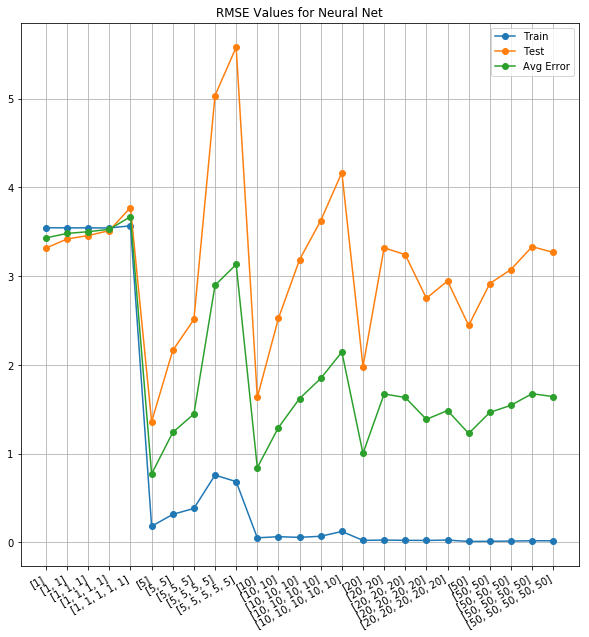

In [508]:
bestHids = getBestAvgNeuralStructure(XtrainW, XtestW, TtrainW, TtestW, 1000, plot=True)

In [610]:
def compareItemToMarket(itemID=19718, allItems=False, stepsAheadToPredict=8, windowSize=9):
    # get data
    if allItems:
        Xtrain, Ttrain, allItems = makeItemData(allItems=allItems, stepsAheadToPredict=stepsAheadToPredict) # training with all items
        Xtest, Ttest, itemTest = makeItemData(itemID, stepsAheadToPredict=stepsAheadToPredict)        
    else: 
        Xtrain, Ttrain, Xtest, Ttest = makeItemData(itemID, splitData=True, stepsAheadToPredict=stepsAheadToPredict)
        
    Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape
    
    # apply rolling windows to data
    XtrainW = rollingWindows(Xtrain, windowSize=windowSize)
    XtestW = rollingWindows(Xtest, windowSize=windowSize)
    TtrainW = Ttrain[:XtrainW.shape[0]]
    TtestW = Ttest[:XtestW.shape[0]]
    XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape
    
    # build and train net
    nnet = nn.NeuralNetwork(XtrainW.shape[1], bestHids, TtrainW.shape[1])
    nnet.train(XtrainW, TtrainW, 2000, verbose=True)

    fig = plt.figure(figsize=(15,15))
    plt.subplot(4,2,1)
    plt.plot(nnet.getErrors())
    print(nnet)

    Ytrain = nnet.use(XtrainW)
    Y = nnet.use(XtestW)

    plt.subplot(4,2,3)
    plt.plot(Y[:,0], label='Predicted ' + Tnames[0])
    plt.plot(TtestW[:,0], label='Target ' + Tnames[0])
    plt.legend();

    plt.subplot(4,2,4)
    plt.plot(Y[:,1], label='Predicted ' + Tnames[1])
    plt.plot(TtestW[:,1], label='Target ' + Tnames[1])
    plt.legend();

    plt.subplot(4,2,5)
    plt.plot(Y[:,2], label='Predicted ' + Tnames[2])
    plt.plot(TtestW[:,2], label='Target ' + Tnames[2])
    plt.legend();

    plt.subplot(4,2,6)
    plt.plot(Y[:,3], label='Predicted ' + Tnames[3])
    plt.plot(TtestW[:,3], label='Target ' + Tnames[3])
    plt.legend();

    plt.subplot(4,2,7)
    plt.plot(Y[:,4], label='Predicted ' + Tnames[4])
    plt.plot(TtestW[:,4], label='Target ' + Tnames[4])
    plt.legend();

    plt.subplot(4,2,8)
    plt.plot(Y[:,5], label='Predicted ' + Tnames[5])
    plt.plot(TtestW[:,5], label='Target ' + Tnames[5])
    plt.legend();

    print("")
    print("Final RMSEs")
    print(Tnames[0], " Train: ", rmse(Ytrain[:,0], TtrainW[:,0]), " Test: ", rmse(Y[:,0], TtestW[:,0]))
    print(Tnames[1], " Train: ", rmse(Ytrain[:,1], TtrainW[:,1]), " Test: ", rmse(Y[:,1], TtestW[:,1]))
    print(Tnames[2], " Train: ", rmse(Ytrain[:,2], TtrainW[:,2]), " Test: ", rmse(Y[:,2], TtestW[:,2]))
    print(Tnames[3], " Train: ", rmse(Ytrain[:,3], TtrainW[:,3]), " Test: ", rmse(Y[:,3], TtestW[:,3]))
    print(Tnames[4], " Train: ", rmse(Ytrain[:,4], TtrainW[:,4]), " Test: ", rmse(Y[:,4], TtestW[:,4]))
    print(Tnames[5], " Train: ", rmse(Ytrain[:,5], TtrainW[:,5]), " Test: ", rmse(Y[:,5], TtestW[:,5]))
    
    return Y

SCG: Iteration 100 fValue Eval 0.0312007430463 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.0273192875838 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.0263505855091 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.0259235146454 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.0255957974997 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.0255084563113 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.025467734663 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.0253760008872 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.0252308375837 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.025213644056 Scale 1e-15
NeuralNetwork(54, [5], 6)
   Network was trained for 1001 iterations that took 2.0071 seconds. Final error is 0.1587880475853976.

Final RMSEs
max_offer_price  Train:  0.480128263021  Test:  0.480132512062
min_sale_price  Train:  0.141457376467  Test:  0.141522176781
offer_availability  Train:  4624.17982492  Test:  4624.17782781
sale_availability  Train:  3155.34311878  Test:  3155.28526314
sale_price_chang

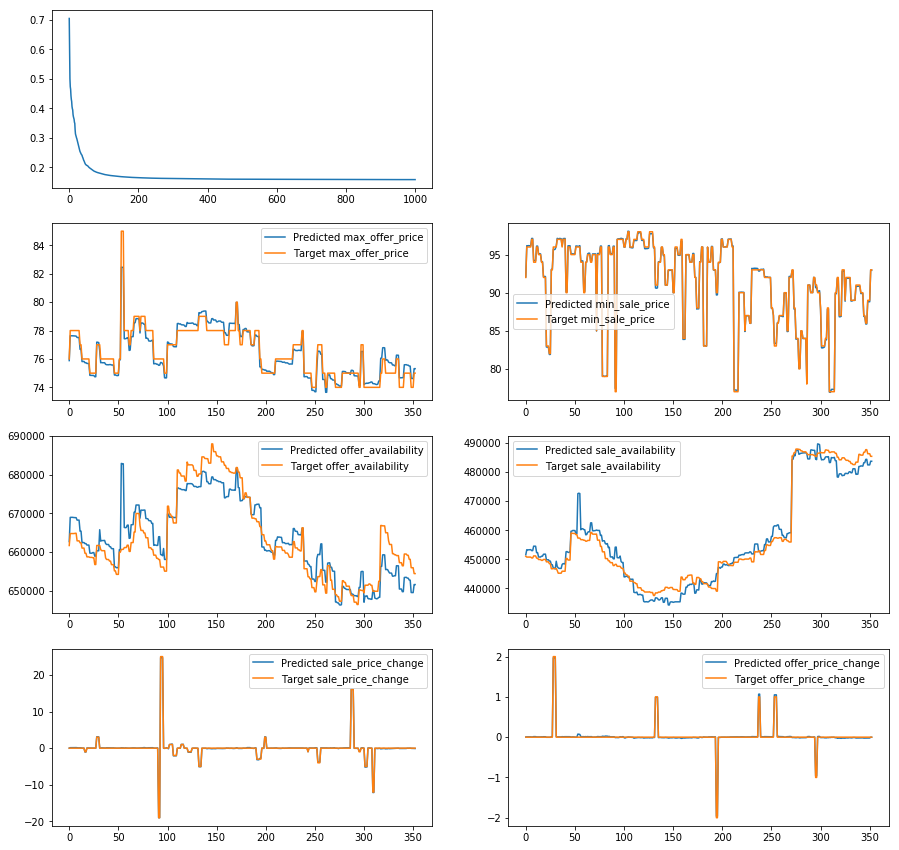

In [512]:
Yall = compareItemToMarket(itemID=19718, allItems=True)

In [615]:
id = 38
spidy.getItemData(itemIDs[id])

{'data_id': 19684,
 'img': 'https://render.guildwars2.com/file/7B0701F4092237431EDC72340BC89AA126EA4EF0/65913.png',
 'max_offer_unit_price': 66,
 'min_sale_unit_price': 80,
 'name': 'Mithril Ingot',
 'offer_availability': 339538,
 'offer_price_change_last_hour': 0,
 'price_last_changed': '2018-05-10 01:01:26 UTC',
 'rarity': 1,
 'restriction_level': 0,
 'result_of': [{'name': 'Mithril Ingot', 'recipe_id': 18}],
 'sale_availability': 2732822,
 'sale_price_change_last_hour': 0,
 'sub_type_id': 0,
 'type_id': 5}

SCG: Iteration 200 fValue Eval 0.0218480614944 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.0200783480228 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.0197358902329 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.0196368045952 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.0195070790774 Scale 1e-15
SCG: Iteration 1200 fValue Eval 0.0194938340051 Scale 1e-15
SCG: Iteration 1400 fValue Eval 0.0194742202078 Scale 1e-15
SCG: Iteration 1600 fValue Eval 0.0194667653848 Scale 1e-15
SCG: Iteration 1800 fValue Eval 0.0194601576077 Scale 1e-15
SCG: Iteration 2000 fValue Eval 0.0194510703724 Scale 1e-15
NeuralNetwork(54, [5], 6)
   Network was trained for 2001 iterations that took 3.4418 seconds. Final error is 0.1394670942278651.

Final RMSEs
max_offer_price  Train:  0.638914740759  Test:  0.870805884356
min_sale_price  Train:  0.20003580898  Test:  0.662990031503
offer_availability  Train:  5739.81893783  Test:  6428.65409064
sale_availability  Train:  12372.3135006  Test:  13943.9641852
sale_price

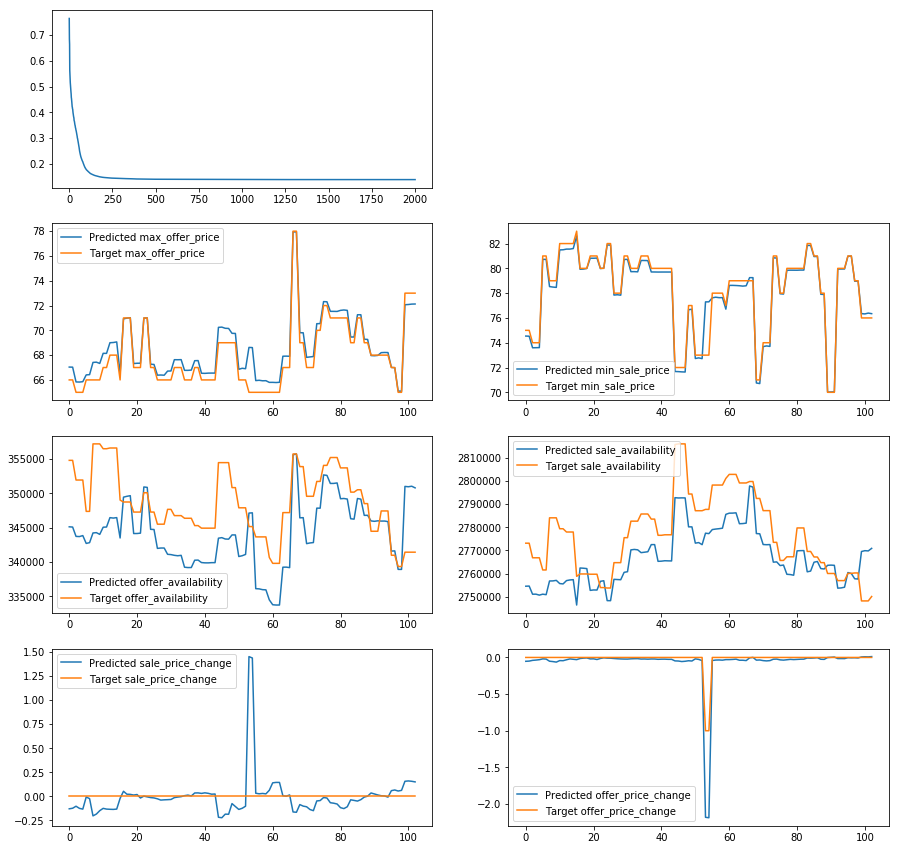

In [616]:
_ = compareItemToMarket(itemIDs[id], allItems=False)

SCG: Iteration 200 fValue Eval 0.0152279788154 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.0138348101386 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.0134847039033 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.013397557392 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.0132348681459 Scale 1e-15
SCG: Iteration 1200 fValue Eval 0.0132182543031 Scale 1e-15
SCG: Iteration 1400 fValue Eval 0.0131927768261 Scale 1e-15
SCG: Iteration 1600 fValue Eval 0.0131772696791 Scale 1e-15
SCG: Iteration 1800 fValue Eval 0.0131688678817 Scale 1e-15
SCG: Iteration 2000 fValue Eval 0.0131595684423 Scale 1e-15
NeuralNetwork(54, [5], 6)
   Network was trained for 2001 iterations that took 3.5510 seconds. Final error is 0.11471516221616752.

Final RMSEs
max_offer_price  Train:  0.226679020729  Test:  1.47840189437
min_sale_price  Train:  0.0877636284812  Test:  0.681032301688
offer_availability  Train:  2867.59554932  Test:  19101.4415276
sale_availability  Train:  1343.42774256  Test:  14317.9238319
sale_pric

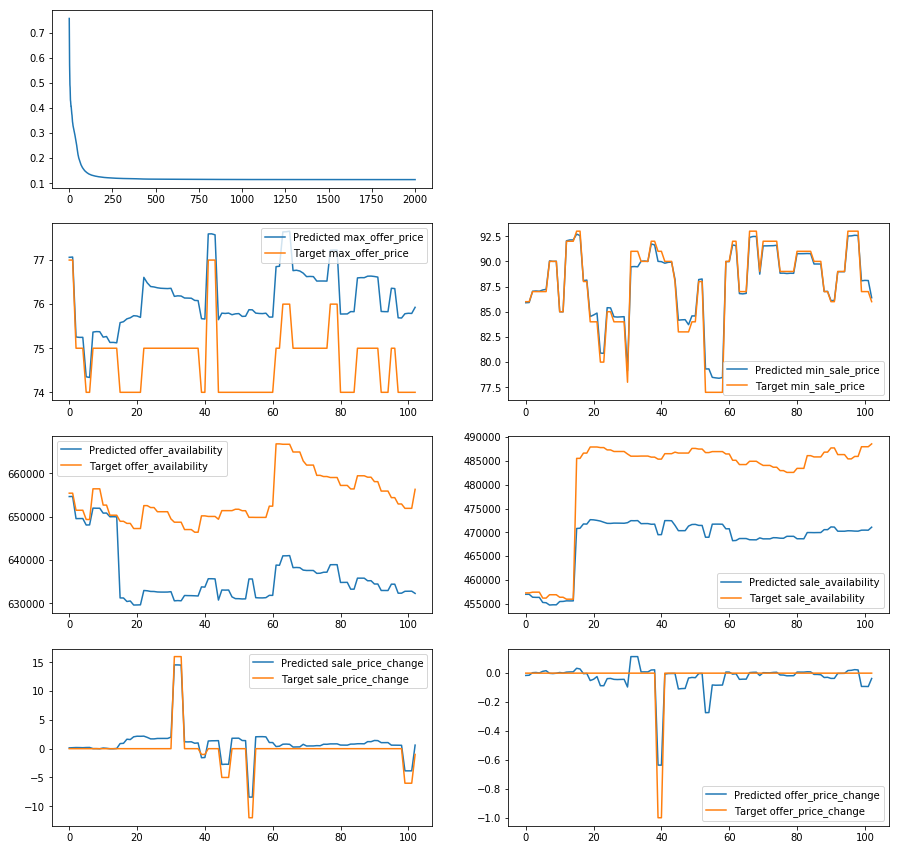

In [612]:
Y = compareItemToMarket(itemID=19718, allItems=False)

In [551]:
def compareAllToMarket():
    netXtrain, netTtrain, item = makeItemData(allItems=True, stepsAheadToPredict=8)
    
    XtrainW = rollingWindows(netXtrain, windowSize=9)
    TtrainW = netTtrain[:XtrainW.shape[0]]
    
    nnet = nn.NeuralNetwork(XtrainW.shape[1], [10], TtrainW.shape[1])
    nnet.train(XtrainW, TtrainW, 2000)
    print(nnet)

    allErrors = np.array([float('inf')]*6)

    for id in itemIDs:   
        Xtest, Ttest, item1 = makeItemData(id, stepsAheadToPredict=8)
        XtestW = rollingWindows(Xtest, windowSize=9)
        TtestW = Ttest[:XtestW.shape[0]]

        Y = nnet.use(XtestW)
        errors = []

        errors = np.array([rmse(Y[:,0], TtestW[:,0]), rmse(Y[:,1], TtestW[:,1]), rmse(Y[:,2], TtestW[:,2]), rmse(Y[:,3], TtestW[:,3]), rmse(Y[:,4], TtestW[:,4]), rmse(Y[:,5], TtestW[:,5])]).reshape(1,6)
        allErrors = np.vstack((allErrors, errors))
    allErrors = pd.DataFrame(allErrors)
    lowestErrors = np.amin(allErrors, axis=0)
        
    return (allErrors, lowestErrors)

In [592]:
def makeComparisons(subItemIDs):
    allErrors = np.array([float('inf')]*6)
    
    
    # for some reason items 31 and 32 are failing to work in this loop
    for id in subItemIDs:   
        Xtrain, Ttrain, Xtest, Ttest = makeItemData(id, splitData=True, stepsAheadToPredict=8)
        XtrainW = rollingWindows(Xtrain, windowSize=9)
        TtrainW = netTtrain[:XtrainW.shape[0]]
        XtestW = rollingWindows(Xtest, windowSize=9)
        TtestW = Ttest[:XtestW.shape[0]]

        nnet = nn.NeuralNetwork(XtrainW.shape[1], [10,10,10], TtrainW.shape[1])
        nnet.train(XtrainW, TtrainW, 2000)
        print(nnet)
        
        Y = nnet.use(XtestW)
        errors = []

        errors = np.array([rmse(Y[:,0], TtestW[:,0]), rmse(Y[:,1], TtestW[:,1]), rmse(Y[:,2], TtestW[:,2]), rmse(Y[:,3], TtestW[:,3]), rmse(Y[:,4], TtestW[:,4]), rmse(Y[:,5], TtestW[:,5])]).reshape(1,6)
        allErrors = np.vstack((allErrors, errors))
    allErrors = pd.DataFrame(allErrors)
    lowestErrors = np.amin(allErrors, axis=0)
        
    return (allErrors, lowestErrors)

In [594]:
comparison1_1, lowestErrors1_1 = makeComparisons(itemIDs[:31]) #[:31]
print(comparison1_1)

NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 6.7345 seconds. Final error is 0.0055658393791593215.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 6.7353 seconds. Final error is 0.07380657851194543.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.5529 seconds. Final error is 0.05790096786805938.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.2654 seconds. Final error is 0.1747415567425733.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 7.8467 seconds. Final error is 0.07118508271012663.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.5087 seconds. Final error is 0.09060665718032221.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.3333 seconds. Final error is 0.07284881745523403.
NeuralNetwork(54, [

In [596]:
comparison1_2, lowestErrors1_2 = makeComparisons(itemIDs[33:]) #[33:]
print(comparison1_1)

NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.3380 seconds. Final error is 0.06130975231194844.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.0908 seconds. Final error is 0.06948157554444692.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.3240 seconds. Final error is 0.07535221141511073.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.3146 seconds. Final error is 0.05944435485076118.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 7.4722 seconds. Final error is 0.06553647445232177.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.4921 seconds. Final error is 0.2170560820177543.
NeuralNetwork(54, [10, 10, 10], 6)
   Network was trained for 2001 iterations that took 8.3575 seconds. Final error is 0.0625637754396427.
NeuralNetwork(54, [10,

In [ ]:
allErrors, lowestErrors = compareAllToMarket()
print(allErrors)

## Results

For some reason, giving a window size of 1 timepoint larger than the steps ahead to predict gives best accuracy

## Conclusions

## References

## Word Count

In [1340]:
import io
from IPython.nbformat import current
import glob
nbfile = glob.glob('TermProject.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file TermProject.ipynb is 63
